### Load Data from Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Modules

In [3]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np


### Read vehicles CSV file as dataframe.

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Berkeley/module_11/vehicles.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

### Split Data

In [12]:
auto_X = df.drop(['price'], axis=1)
auto_y = df['price']
auto_X_train, auto_X_test, auto_y_train, auto_y_test = train_test_split(auto_X, auto_y,
                                                                       test_size = 0.3,
                                                                       random_state = 42)

In [13]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
auto_X_train.describe()

,id,year,odometer
count,298816.00,297945.00,295703.00
mean,7311485647.53,2011.22,97675.73
std,4471182.82,9.49,207367.86
min,7207408119.00,1900.00,0.00
25%,7308146377.75,2008.00,37668.50
50%,7312606440.50,2013.00,85527.00
75%,7315251390.50,2017.00,133516.00
max,7317101084.00,2022.00,10000000.00


Remove outliers

### Check missing values percentage.


In [14]:
missing_perc = round(auto_X_train.isnull().sum() * 100 / len(df), 2)
# missing_perc = missing_perc[missing_perc > 0]
print(missing_perc.sort_values())

id              0.00
state           0.00
region          0.00
year            0.20
transmission    0.42
fuel            0.48
odometer        0.73
model           0.87
title_status    1.35
manufacturer    2.89
type           15.26
paint_color    21.39
drive          21.42
VIN            26.38
condition      28.61
cylinders      29.14
size           50.22
dtype: float64


### Drop and Impute Training dataset.

In [15]:
auto_X_train = auto_X_train.drop(columns=['size', 'VIN'])
auto_X_train.dropna(thresh=len(df.columns) * .5, axis=0)
print(auto_X_train.columns)
numeric_cols = ['year', 'odometer']
categorical_cols = ['transmission', 'fuel', 'model', 'title_status', 'paint_color', 'drive', 'condition', 'cylinders', 'manufacturer', 'type']

num_imputer = SimpleImputer(strategy='mean')
auto_X_train[numeric_cols] = num_imputer.fit_transform(auto_X_train[numeric_cols])


# Impute categorical features with the most frequent value
cat_imputer = SimpleImputer(strategy='most_frequent')
auto_X_train[categorical_cols] = cat_imputer.fit_transform(auto_X_train[categorical_cols])

missing_perc = round(auto_X_train.isnull().sum() * 100 / len(auto_X_train), 2)
print(missing_perc)

Index(['id', 'region', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'type', 'paint_color', 'state'],
      dtype='object')
id             0.00
region         0.00
year           0.00
manufacturer   0.00
model          0.00
condition      0.00
cylinders      0.00
fuel           0.00
odometer       0.00
title_status   0.00
transmission   0.00
drive          0.00
type           0.00
paint_color    0.00
state          0.00
dtype: float64


# Tansform and impute test data


In [16]:
auto_X_test.describe()

,id,year,odometer
count,128064.00,127730.00,126777.00
mean,7311488936.52,2011.27,98900.75
std,4477821.31,9.36,228351.95
min,7212512589.00,1900.00,0.00
25%,7308140612.75,2008.00,37733.00
50%,7312677826.00,2013.00,85567.00
75%,7315258483.50,2017.00,133654.00
max,7317096685.00,2022.00,10000000.00


In [ ]:
def remove_outlier_using_iqr(df, column):
  q1 = df[column].quantile(.25)
  q3 = df[column].quantile(.75)
  iqr = q3 - q1

  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr
  # print(iqr, lower_bound, upper_bound)
  df_filtered = df.query(f'{column} >= {lower_bound} and {column} <= {upper_bound}')
  return df_filtered

def remove_outlier_using_zscore(df, column, thres=3):
  z_score = np.abs((df[column] - df[column].mean()) / df[column].std())
  return df[(z_score < thres)]


# df_cleaned = df[df['year'] >= 2009]
df_cleaned = df_new[df_new['price'] > 5000]
df_cleaned = df_cleaned[df_cleaned['odometer'] > 3000]
df_cleaned = remove_outlier_using_iqr(df_cleaned, 'price')
df_cleaned = remove_outlier_using_iqr(df_cleaned, 'odometer')
df_cleaned = remove_outlier_using_iqr(df_cleaned, 'year')
df_cleaned.info()
# df = df[df['price'] < 1000000]
# df = df[df['price'] > 5000]
# df = df[df['year'] >= 2001]
# df = df[df['odometer'] >= 5000]
# df_cleaned = remove_outlier_using_zscore(df_new, 'price')
# df_cleaned = remove_outlier_using_zscore(df_cleaned, 'year')

# df_cleaned = remove_outlier_using_zscore(df_cleaned, 'odometer')

df_cleaned.describe()


<class 'pandas.core.frame.DataFrame'>
Index: 296985 entries, 0 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            296985 non-null  int64  
 1   region        296985 non-null  object 
 2   price         296985 non-null  int64  
 3   year          296985 non-null  float64
 4   manufacturer  296985 non-null  object 
 5   model         296985 non-null  object 
 6   condition     296985 non-null  object 
 7   cylinders     296985 non-null  object 
 8   fuel          296985 non-null  object 
 9   odometer      296985 non-null  float64
 10  title_status  296985 non-null  object 
 11  transmission  296985 non-null  object 
 12  drive         296985 non-null  object 
 13  type          296985 non-null  object 
 14  paint_color   296985 non-null  object 
 15  state         296985 non-null  object 
dtypes: float64(2), int64(2), object(12)
memory usage: 38.5+ MB


,id,price,year,odometer
count,296985.00,296985.00,296985.00,296985.00
mean,7311325882.94,20892.93,2013.58,84751.82
std,4488732.18,11917.05,4.43,54056.44
min,7207408119.00,5015.00,2000.00,3002.00
25%,7307898345.00,10885.00,2011.00,37333.00
50%,7312258753.00,18200.00,2014.00,80305.00
75%,7315109372.00,28998.00,2017.00,122440.00
max,7317101084.00,58961.00,2022.00,253402.00


In [ ]:
df_new.nunique().sort_values()

,0
transmission,3
drive,3
fuel,5
condition,6
title_status,6
cylinders,8
paint_color,12
type,13
manufacturer,42
state,51


In [ ]:
cat_columns = ['transmission', 'drive', 'fuel', 'condition', 'title_status', 'cylinders', 'paint_color', 'type']
for col in cat_columns:
  if df_cleaned[col].dtype == object:
    print(f'Unique values for column {col}: {df_cleaned[col].unique()}')

Unique values for column transmission: ['automatic' 'other' 'manual']
Unique values for column drive: ['4wd' 'rwd' 'fwd']
Unique values for column fuel: ['gas' 'other' 'diesel' 'hybrid' 'electric']
Unique values for column condition: ['good' 'excellent' 'like new' 'new' 'fair' 'salvage']
Unique values for column title_status: ['clean' 'rebuilt' 'lien' 'salvage' 'missing' 'parts only']
Unique values for column cylinders: ['6 cylinders' '8 cylinders' '4 cylinders' '5 cylinders' '10 cylinders'
 '12 cylinders' 'other' '3 cylinders']
Unique values for column paint_color: ['white' 'blue' 'red' 'black' 'silver' 'grey' 'brown' 'yellow' 'orange'
 'custom' 'green' 'purple']
Unique values for column type: ['sedan' 'pickup' 'truck' 'other' 'coupe' 'SUV' 'hatchback' 'mini-van'
 'offroad' 'bus' 'convertible' 'wagon' 'van']


<Axes: ylabel='price'>

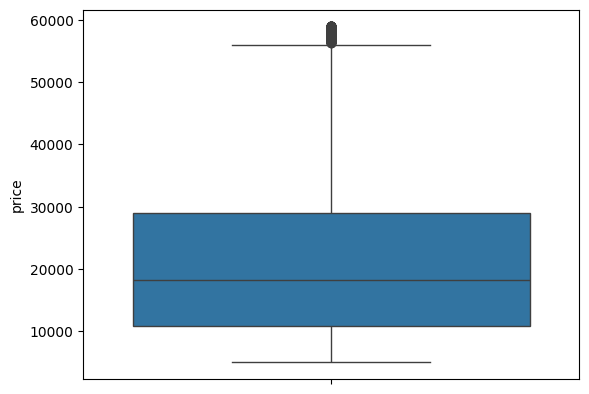

In [ ]:
sns.boxplot(data=df_cleaned['price'])